## Xarray engine: chunks on a Dask cluster

First, set up a default Dask cluster.

In [ ]:
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:53324,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:53342,Total threads: 2
Dashboard: http://127.0.0.1:53347/status,Memory: 3.20 GiB
Nanny: tcp://127.0.0.1:53327,


Next, we get 2m temperature data for a whole year on a low resolution regular latitude-longitude grid. It contains 2 fields per day (at 0 and 6 UTC). This data obviously fits into memory, so only used for demonstration purposes.

In [ ]:
import earthkit.data as ekd
ds_fl = ekd.from_source("sample", "t2_1_year_hourly.grib")
len(ds_fl)

732

Now, we convert the GRIB Fieldlist to Xarray using the chunk size of 10 fields.

In [ ]:
ds = ds_fl.to_xarray(time_dim_mode="valid_time", 
                     chunks={"valid_time": 10}, 
                     add_earthkit_attrs=False)
ds["2t"]

<xarray.DataArray '2t' (valid_time: 732, latitude: 13, longitude: 24)> Size: 2MB
dask.array<open_dataset-2t, shape=(732, 13, 24), dtype=float64, chunksize=(10, 13, 24), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 6kB 2020-01-01 ... 2020-12-31T06:...
  * latitude    (latitude) float64 104B 90.0 75.0 60.0 ... -60.0 -75.0 -90.0
  * longitude   (longitude) float64 192B 0.0 15.0 30.0 ... 315.0 330.0 345.0
Attributes:
    standard_name:  air_temperature
    long_name:      2 metre temperature
    units:          K

Finally, we compute the mean along the temporal dimension. Xarray will load data in chunks for this computation keeping the memory usage low.

In [ ]:
m = ds["2t"].mean(dim="valid_time").load()
m

<xarray.DataArray '2t' (latitude: 13, longitude: 24)> Size: 2kB
array([[259.17798273, 259.17798273, 259.17798273, 259.17798273,
        259.17798273, 259.17798273, 259.17798273, 259.17798273,
        259.17798273, 259.17798273, 259.17798273, 259.17798273,
        259.17798273, 259.17798273, 259.17798273, 259.17798273,
        259.17798273, 259.17798273, 259.17798273, 259.17798273,
        259.17798273, 259.17798273, 259.17798273, 259.17798273],
       [273.2611026 , 275.61228088, 275.48984236, 274.29307835,
        268.16812105, 267.89195131, 264.09208792, 262.4144496 ,
        262.67648853, 261.67375629, 261.81749775, 261.75990725,
        261.65672248, 261.12205718, 260.31177713, 259.69160124,
        259.44480308, 258.91397999, 256.69544345, 261.1351634 ,
        263.80255581, 245.3709899 , 246.22366237, 263.91035124],
       [281.80054932, 277.3069957 , 278.84242945, 276.02408075,
        274.49351381, 274.21627678, 274.1331996 , 272.61215281,
        271.49176346, 269.63533416, 273.44181469, 275.6214595 ,
        276.75602234, 275.00730308, 276.87611285, 273.58944106,
        271.92337207, 268.99705718, 266.13354113, 265.23450595,
        271.60276073, 273.63473648, 279.19937105, 281.8119052 ],
       [284.15830206, 283.85715793, 286.20103601, 283.92187788,
        283.76810397, 284.21051346, 282.39472624, 279.20961695,
...
        283.64451278, 283.35801176, 282.91684031, 282.9554759 ,
        282.14711695, 282.26140144, 281.0409011 , 280.42200595],
       [269.24513607, 270.23454864, 271.63341305, 271.82437105,
        271.60942057, 270.65992432, 270.95410978, 271.93656367,
        273.56741237, 274.12688129, 273.18558177, 275.06365554,
        275.63789564, 274.6907901 , 272.28731504, 273.95432323,
        275.29179762, 275.50107016, 275.76251141, 276.15411831,
        273.34336866, 269.42683006, 268.963758  , 268.6785804 ],
       [234.73941544, 228.72784611, 229.33594038, 225.86723307,
        238.04060226, 241.2718608 , 229.15774707, 226.06100868,
        224.74338573, 228.59588744, 232.7254554 , 258.2240039 ,
        257.83465964, 258.4833106 , 262.08999605, 259.26575595,
        256.58991066, 260.79205376, 251.32129728, 250.12530172,
        253.13652952, 256.13648682, 258.81438129, 254.06318594],
       [227.70048102, 227.70048102, 227.70048102, 227.70048102,
        227.70048102, 227.70048102, 227.70048102, 227.70048102,
        227.70048102, 227.70048102, 227.70048102, 227.70048102,
        227.70048102, 227.70048102, 227.70048102, 227.70048102,
        227.70048102, 227.70048102, 227.70048102, 227.70048102,
        227.70048102, 227.70048102, 227.70048102, 227.70048102]])
Coordinates:
  * latitude   (latitude) float64 104B 90.0 75.0 60.0 45.0 ... -60.0 -75.0 -90.0
  * longitude  (longitude) float64 192B 0.0 15.0 30.0 45.0 ... 315.0 330.0 345.0

In the Dask dashboard you should see something like this:

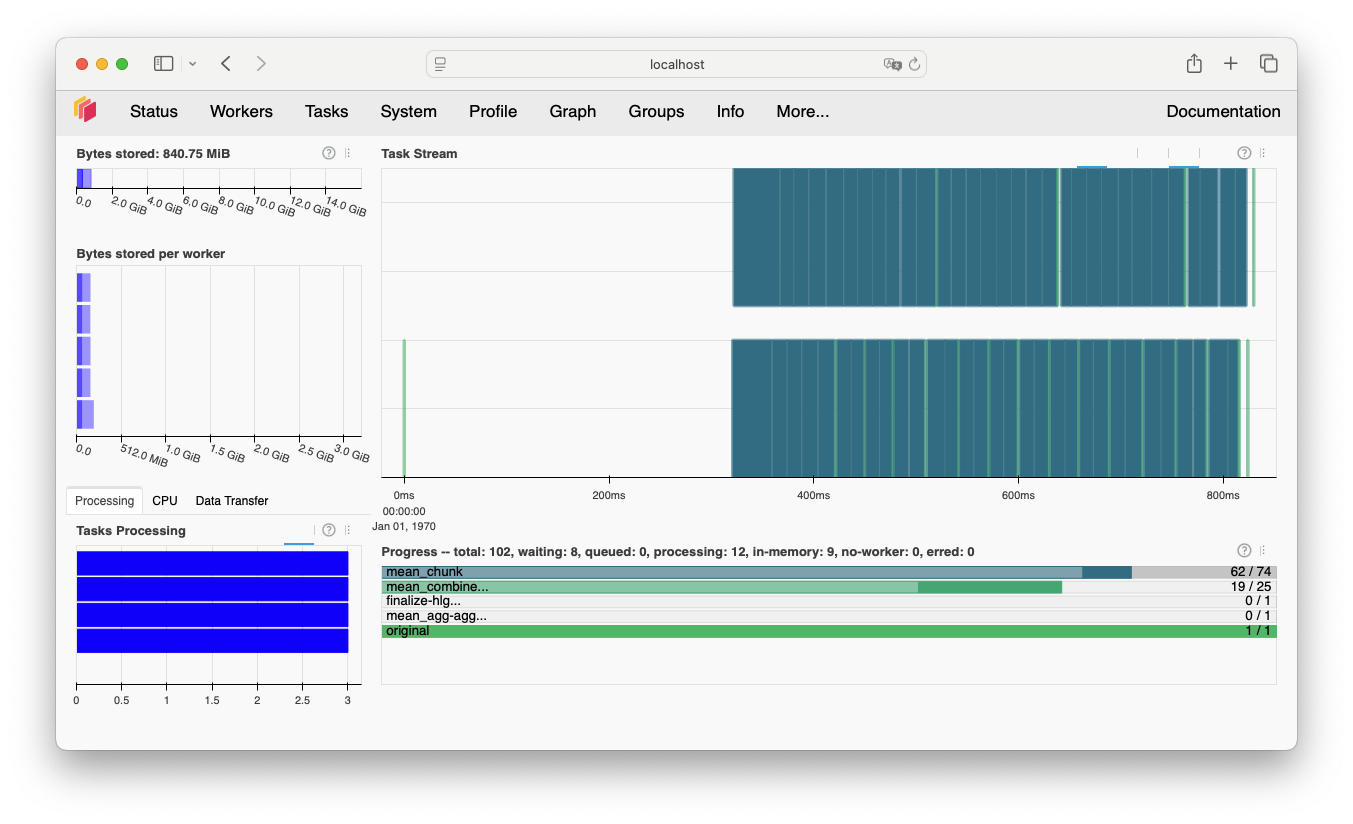